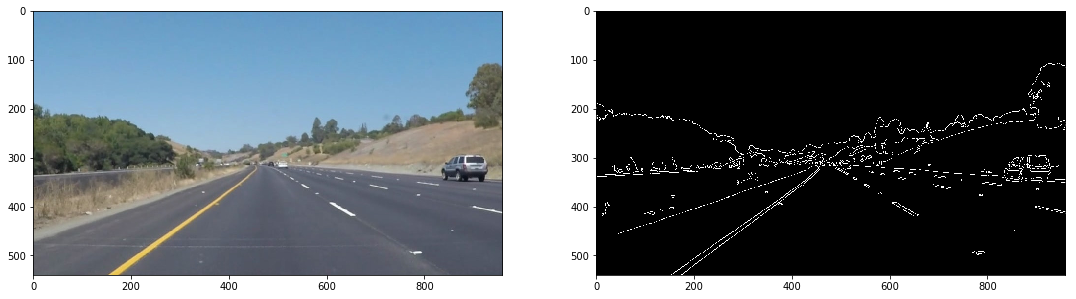

In [28]:
# CANNY EDGE DETECTION

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

# Read in the image and convert to grayscale
image = mpimg.imread('solidYellowCurve-Copy1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(edges, cmap='Greys_r')

plt.show()


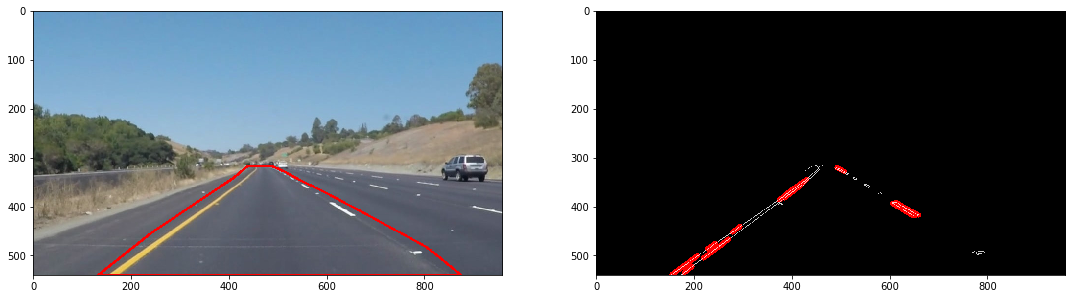

In [29]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

# make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing

# obtain these coordinates using WebPlotDigitizer at https://apps.automeris.io/wpd/
mask_cords = [(131.61331935821977, 540),
(239.42594533580592, 454.7770700636942),
(346.1178747077321, 383.43949044585986),
(408.8768846246877, 341.4012738853503),
(438.9341288397969, 315.9235668789809),
(488.31734257840844, 317.19745222929936),
(511.2311537531243, 327.38853503184714),
(545.6502459082482, 346.4968152866242),
(596.5895347899702, 370.70063694267515),
(678.1504474723858, 414.01273885350315),
(803.0557123276627, 481.5286624203821),
(874.6512940417642, 540)]


mask_cords = np.round(mask_cords)
mask_cords = mask_cords.astype(int)
mask_cords = tuple(map(tuple,mask_cords))

# Draw a line with thickness of 4 px
ic = 1
while (ic<len(mask_cords)):
    region_select = cv2.line(region_select,mask_cords[ic-1],mask_cords[ic],(255,0,0),4)
    ic = ic+1
    
region_select = cv2.line(region_select,mask_cords[-1],mask_cords[0],(255,0,0),4)


# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255

# This time we are defining a n sided polygon to mask
imshape = image.shape
vertices = np.array([mask_cords], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 15
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
m_parm = []
n_parm = []
x1_parm = []
y1_parm = []
x2_parm = []
y2_parm = []

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        m_parm.append((y2-y1)/(x2-x1))
        x1_parm.append(x1)
        y1_parm.append(y1)
        x2_parm.append(x2)
        y2_parm.append(y2)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(region_select, cmap='Greys_r')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(combo)

plt.show()


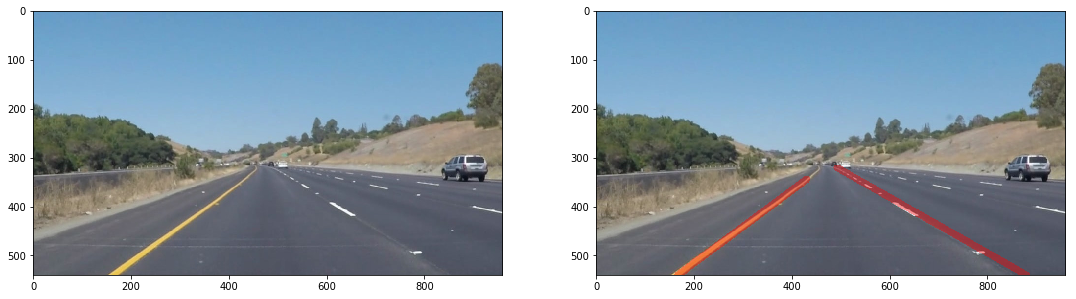

In [30]:
# DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
# USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
# ONCE SORTED DETERMINE 
# > AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
# > MIN Y FOR EACH OF EACH OF LEFT AND RIGHT LANES AND CORRESPONDING X
# > using MEAN SLOPES AND and MIN Ys and CORRESPONDING Xs DETERMINE bs in y=mx+b
# > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) DETERMINE CORRESPONDING X

# Capture all (x,y) coordinates for the masked edge lines
m_parm = np.asarray(m_parm)
x1_parm = np.asarray(x1_parm)
y1_parm = np.asarray(y1_parm)
x2_parm = np.asarray(x2_parm)
y2_parm = np.asarray(y2_parm)

mp_sort = sorted(m_parm)
x1_sort = x1_parm[np.argsort(m_parm)]
y1_sort = y1_parm[np.argsort(m_parm)]
x2_sort = x2_parm[np.argsort(m_parm)]
y2_sort = y2_parm[np.argsort(m_parm)]

mp_neg = list(filter(lambda x: x < 0, m_parm)) 
mp_neg_len = len(mp_neg)

mp_neg_x1 = x1_sort[0:mp_neg_len]
mp_neg_y1 = y1_sort[0:mp_neg_len]
mp_neg_x2 = x2_sort[0:mp_neg_len]
mp_neg_y2 = y2_sort[0:mp_neg_len]

mp_neg_x = np.hstack((mp_neg_x1,mp_neg_x2))
mp_neg_y = np.hstack((mp_neg_y1,mp_neg_y2))

min_neg_y = np.min(mp_neg_y)
min_neg_yx = mp_neg_x[np.argmin(mp_neg_y)]

lmn_x1y1 = (min_neg_yx,min_neg_y)

mmp_neg = np.mean(mp_neg)
bp_neg = min_neg_y-mmp_neg*min_neg_yx
lmn_x2 = int(round((ysize-bp_neg)/mmp_neg))
lmn_x2y2 = (lmn_x2,ysize)

mp_pos = list(filter(lambda x: x > 0, m_parm))
mp_pos_x1 = x1_sort[(mp_neg_len-1):]
mp_pos_y1 = y1_sort[(mp_neg_len-1):]
mp_pos_x2 = x2_sort[(mp_neg_len-1):]
mp_pos_y2 = y2_sort[(mp_neg_len-1):]

mp_pos_x = np.hstack((mp_pos_x1,mp_pos_x2))
mp_pos_y = np.hstack((mp_pos_y1,mp_pos_y2))

min_pos_y = np.min(mp_pos_y)
min_pos_yx = mp_pos_x[np.argmin(mp_pos_y)]
lmp_x1y1 = (min_pos_yx,min_pos_y)

mmp_pos = np.mean(mp_pos)
bp_pos = min_pos_y-mmp_pos*min_pos_yx
lmp_x2 = int(round((ysize-bp_pos)/mmp_pos))
lmp_x2y2 = (lmp_x2,ysize)


lane_select = np.copy(image)
# Draw a line with thickness of 4 px
lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),14)
lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),14)

lane_ext_bf1 = np.copy(lane_select)
lane_ext_bf2 = np.copy(lane_select)

alpha = 0.4  # Transparency factor.
lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)


# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_select)

plt.show()

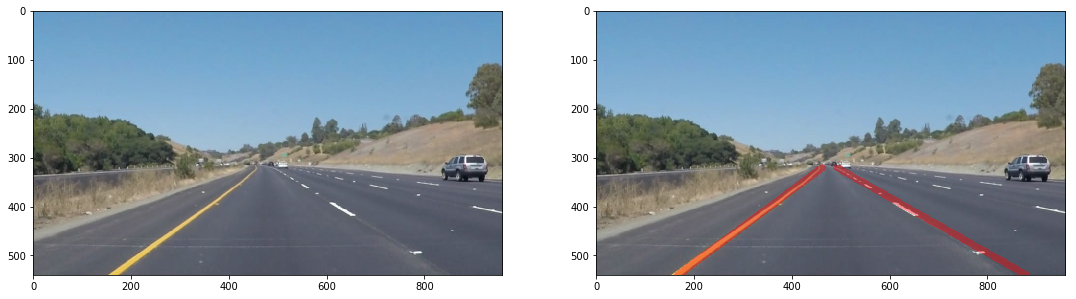

In [31]:
# EXTRAPOLATION
# PATCHING LEFT LINE TO BE EQUAL TO RIGHT LINE
# TWO WAYS OF DOING THIS
# BRUTE FROCE METHOD \
# DETERMINE MIN Y ON RIGHT LINE
# AND
# EXTEND LEFT LINE TO THE MIN Y FROM RIGHT LINE

x_vec = [lmn_x1y1[0], lmn_x2y2[0],lmp_x1y1[0],lmp_x2y2[0]]
y_vec = [lmn_x1y1[1], lmn_x2y2[1],lmp_x1y1[1],lmp_x2y2[1]]
ys_vec = ['lmn_y1','lmn_y2','lmp_y1','lm_y2']

y_min = np.min(y_vec)
ys_min = ys_vec[np.argmin(y_vec)]
# lmp_y1 is lowest
# need to extend -ve m parameter (left line associated with -ve m)
y_mn = [lmn_x1y1[1], lmn_x2y2[1]]
ys_mn = ['lmn_y1','lmn_y2']
ymn_min = np.min(y_mn)
ysmn_min = ys_mn[np.argmin(y_mn)]

lmp_y1 = min_pos_y
lmn_x0 = int(round((lmp_y1-bp_neg)/mmp_neg))
lmn_x0y0 = (lmn_x0,lmp_y1)

lane_ext_bf1 = cv2.line(lane_ext_bf1,lmn_x1y1,lmn_x0y0,(255,0,0),14)

alpha = 0.4  # Transparency factor.
lane_ext_bf1 = cv2.addWeighted(lane_ext_bf1, alpha, image, 1 - alpha, 0)

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_ext_bf1)

plt.show()


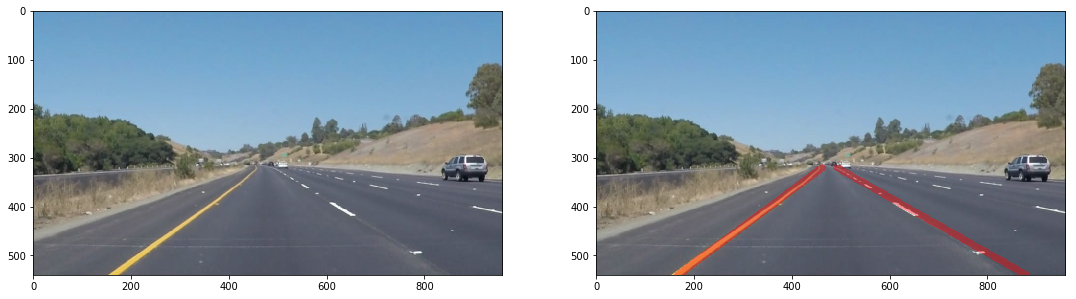

In [32]:
# EXTRAPOLATION
# PATCHING LEFT LINE TO BE EQUAL TO RIGHT LINE
# TWO WAYS OF DOING THIS
# LEFT AND RIGHT LANES ARE MERGING
# DETERMINE DIFF OF x BETWEEN LEFT AND RIGHT LANES AS A FUNCTION OF Y-AXIS
# ADD DIFF OF x AT MIN Y TO DETERMINE NEW x0 FOR THE LEFT LANE

ya_vec = np.arange(350,525,25)
xv_neg = (ya_vec-bp_neg)/mmp_neg
xv_pos = (ya_vec-bp_pos)/mmp_pos
x_diff = np.absolute(xv_neg-xv_pos)
x_diff = np.rint(x_diff)
x_diff = x_diff.astype(int)
xd_pf = np.polyfit(ya_vec, x_diff, 1)

x_vec = [lmn_x1y1[0], lmn_x2y2[0],lmp_x1y1[0],lmp_x2y2[0]]
y_vec = [lmn_x1y1[1], lmn_x2y2[1],lmp_x1y1[1],lmp_x2y2[1]]

y_min = np.min(y_vec)
xd_ymin = xd_pf[0]*y_min+xd_pf[1]

xright_ymin = x_vec[np.argmin(y_vec)]
xleft_ymin = xright_ymin-xd_ymin
xleft_ymin = np.rint(xleft_ymin)
xleft_ymin = xleft_ymin.astype(int)

xv_sort = np.sort(x_vec)
xv_asort = np.argsort(x_vec)
yv_sort = np.asarray(y_vec)[xv_asort]

lmn_x0y0_bf2 = (xleft_ymin,y_min)
lmn_x1y1_bf2 = (xv_sort[1],yv_sort[1])

lane_ext_bf2 = cv2.line(lane_ext_bf2,lmn_x1y1_bf2,lmn_x0y0_bf2,(255,0,0),14)

alpha = 0.4  # Transparency factor.
lane_ext_bf2 = cv2.addWeighted(lane_ext_bf2, alpha, image, 1 - alpha, 0)

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_ext_bf2)

plt.show()
